# install mamba

In [ ]:
!wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh

In [ ]:
!sudo bash Miniforge3-Linux-x86_64.sh -bfp /usr/local

In [ ]:
!rm Miniforge3-Linux-x86_64.sh

# install other packages

In [ ]:
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

In [ ]:
print(python_version)

In [ ]:
PYTHON_VERSION = python_version

In [ ]:
!sudo mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.0.0 python='{PYTHON_VERSION}' pdbfixer

# install ColabFold & Jax_cuda

In [ ]:
!pip install --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"

In [ ]:
!pip install colabfold[alphafold]

In [ ]:
!pip install --upgrade "jax[cuda12]"==0.4.35

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install silence_tensorflow

In [1]:
!pip freeze | grep jax

jax==0.4.35
jax-cuda12-pjrt==0.4.35
jax-cuda12-plugin==0.4.35
jaxlib==0.4.34


In [2]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 5 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_a5e17_1
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

# run prediction

2025-03-04 01:34:53.148451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741052093.171599   92097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741052093.179320   92097 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2025-03-04 01:34:54,775 Running on GPU
2025-03-04 01:34:55,182 Found 9 citations for tools or databases
2025-03-04 01:34:55,182 Query 1/1: test_a5e17_1 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2025-03-04 01:35:03,308 Sequence 0 found templates: ['3mb2_C', '6bgn_C', '2fm7_B', '4fdx_A', '1otf_D', '3ry0_B', '1bjp_A', '7m59_B', '6fps_P', '5cln_I', '6fps_R', '5clo_C', '3abf_B', '4faz_C', '7xuy_A', '7puo_F', '4x1c_F', '6ogm_L', '7puo_F', '2op8_A']


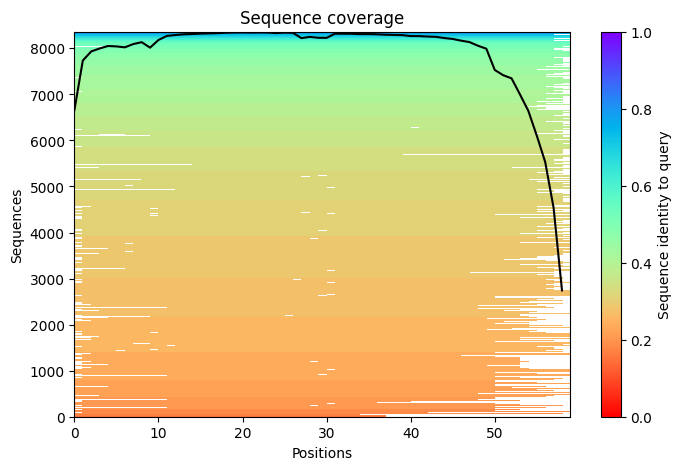

2025-03-04 01:35:04,714 Setting max_seq=512, max_extra_seq=5120


I0000 00:00:1741052114.718318   92097 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


2025-03-04 01:35:42,395 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=97.9 pTM=0.786
2025-03-04 01:35:47,336 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=97.9 pTM=0.791 tol=0.108
2025-03-04 01:35:52,296 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=97.9 pTM=0.791 tol=0.0374
2025-03-04 01:35:57,273 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=97.8 pTM=0.788 tol=0.0245
2025-03-04 01:35:57,274 alphafold2_ptm_model_1_seed_000 took 41.7s (3 recycles)


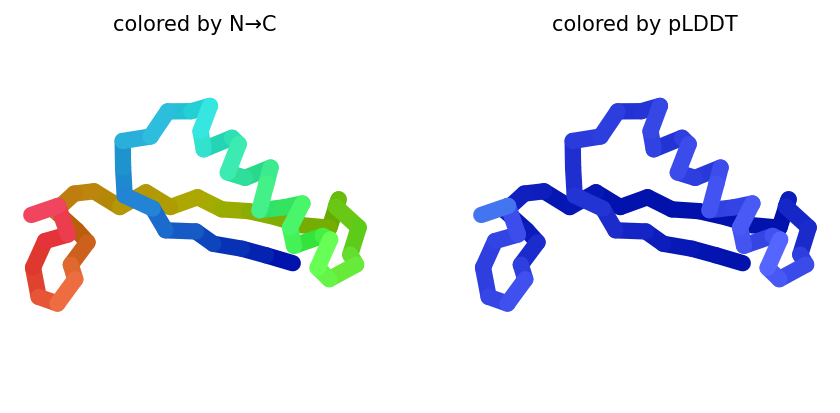

2025-03-04 01:36:02,422 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=97.9 pTM=0.795
2025-03-04 01:36:07,437 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97.9 pTM=0.802 tol=0.063
2025-03-04 01:36:12,468 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=97.9 pTM=0.801 tol=0.0291
2025-03-04 01:36:17,516 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=97.8 pTM=0.8 tol=0.0198
2025-03-04 01:36:17,517 alphafold2_ptm_model_2_seed_000 took 20.1s (3 recycles)


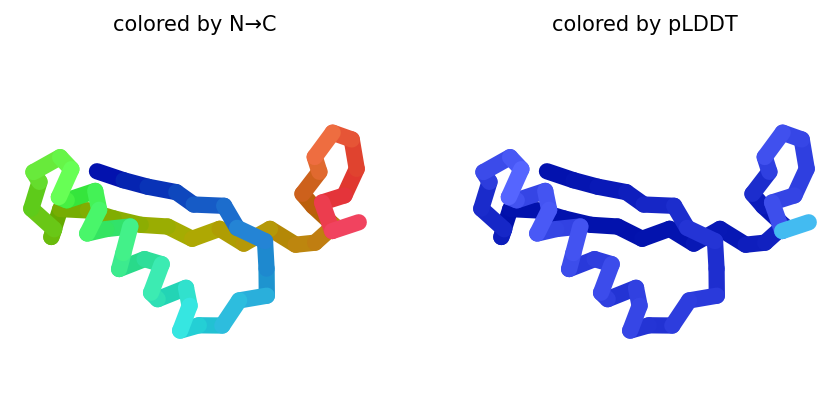

2025-03-04 01:36:35,566 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.774
2025-03-04 01:36:40,532 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.783 tol=0.288
2025-03-04 01:36:45,513 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.5 pTM=0.783 tol=0.0825
2025-03-04 01:36:50,502 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.783 tol=0.0626
2025-03-04 01:36:50,503 alphafold2_ptm_model_3_seed_000 took 32.9s (3 recycles)


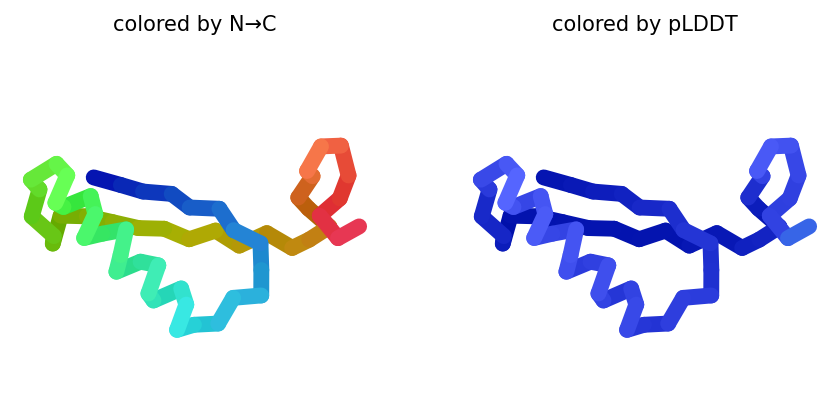

2025-03-04 01:36:55,586 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.3 pTM=0.772
2025-03-04 01:37:00,609 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.249
2025-03-04 01:37:05,616 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.2 pTM=0.78 tol=0.0481
2025-03-04 01:37:10,619 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=96.9 pTM=0.778 tol=0.0445
2025-03-04 01:37:10,620 alphafold2_ptm_model_4_seed_000 took 20.0s (3 recycles)


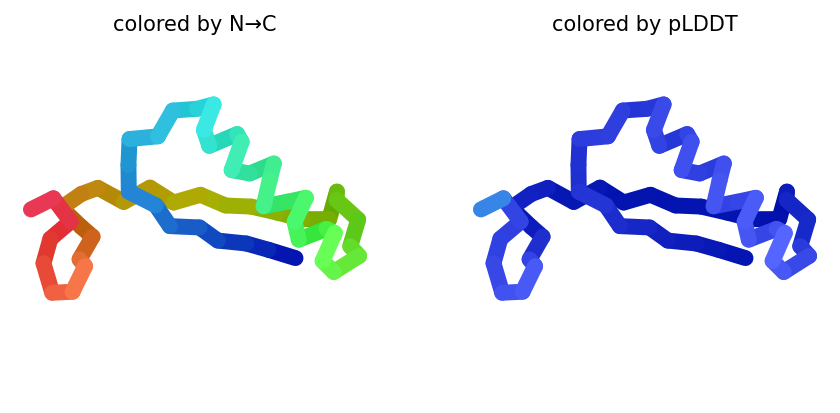

2025-03-04 01:37:15,759 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.783
2025-03-04 01:37:20,745 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=97 pTM=0.785 tol=0.24
2025-03-04 01:37:25,726 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.3 pTM=0.778 tol=0.177
2025-03-04 01:37:30,691 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.1 pTM=0.776 tol=0.132
2025-03-04 01:37:30,692 alphafold2_ptm_model_5_seed_000 took 19.9s (3 recycles)


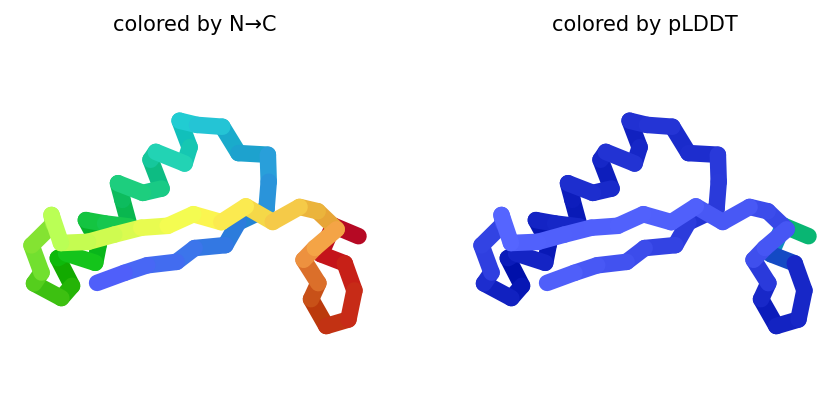

2025-03-04 01:37:30,778 reranking models by 'plddt' metric
2025-03-04 01:37:35,449 Relaxation took 4.7s
2025-03-04 01:37:35,450 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=97.8 pTM=0.8
2025-03-04 01:37:37,849 Relaxation took 2.4s
2025-03-04 01:37:37,849 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=97.8 pTM=0.788
2025-03-04 01:37:40,797 Relaxation took 2.9s
2025-03-04 01:37:40,797 rank_003_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.783
2025-03-04 01:37:43,118 Relaxation took 2.3s
2025-03-04 01:37:43,118 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=96.9 pTM=0.778
2025-03-04 01:37:45,951 Relaxation took 2.8s
2025-03-04 01:37:45,952 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=96.1 pTM=0.776
2025-03-04 01:37:47,053 Done


sh: 1: zip: not found


32512

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

# Display 3D Structure

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import torch as tf
print(tf.__version__)

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


In [ ]:
import sys
sys.modules['tensorflow']

In [ ]:
!which torch

In [ ]:
import os
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/.local/bin')

In [ ]:
import os

# Store the path in a Python variable
COLABFOLDDIR = os.path.join(os.getcwd(), "localcolabfold")

# Use the variable in a shell command
!mkdir -p "{COLABFOLDDIR}"

In [ ]:
!cd "{COLABFOLDDIR}" && pwd  # Confirm it worked

In [ ]:
!wget -q -P . https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh

In [ ]:
!bash ./Miniforge3-Linux-x86_64.sh -b -p "{COLABFOLDDIR}/conda"

In [ ]:
!rm Miniforge3-Linux-x86_64.sh

In [ ]:
!source "{COLABFOLDDIR}/conda/etc/profile.d/conda.sh"

In [ ]:
!conda --version